## Installation


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import packages

In [ ]:
import pandas as pd
import os
import numpy as np
import sys
import json
import random
import torch
import logging
import threading
import nltk
import re
import string
import traceback
import math
import functools as ft
import time
import shutil

from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, DistilBertTokenizer, EarlyStoppingCallback, TrainingArguments, Trainer, BertForSequenceClassification, DistilBertForSequenceClassification, EvalPrediction, BertConfig
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

### Download packages

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load dataset

In [ ]:
infile = "/content/elonmusk_doge_tweets.csv"
# infile = "/content/drive/MyDrive/SMBA_2022/elonmusk_doge_tweets.gsheet"

# reading the dataset
df = pd.read_csv(infile, encoding = "utf-8")
df.head()

,tweet_id,original_tweet,cleaned_tweeet,year,month,day,time,labels
0,1.250000e+18,@28delayslater @justpaulinelol Dogecoin Mode,dogecoin mode,2020,4,25,13:29:52,1
1,1.280000e+18,"@izzynobre Excuse me, I only sell Doge!","excuse me, i only sell doge!",2020,7,18,00:53:43,-1
2,1.340000e+18,One word: Doge,one word: doge,2020,12,20,09:30:04,1
3,1.420000e+18,@AshleyIllusion1 @lexfridman Lil X is hodling ...,lil x is hodling his doge like a champ. litera...,2021,7,17,16:53:53,0
4,1.410000e+18,"@CGDaveMac Maybe if it sees a Shiba Inu, the c...","maybe if it sees a shiba inu, the car renders ...",2021,7,13,02:33:26,0


## Preprocessing the dataset

### Preprocessing steps

In [ ]:
# remove all numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [ ]:
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
# tokenize a string
def tokenize(text):
    word_tokens = word_tokenize(text)
    return word_tokens

In [ ]:
stop_words = set(stopwords.words("english"))

# remove stopwords function
def remove_stopwords(word_tokens):
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

In [ ]:
lemmatizer = WordNetLemmatizer()

# lemmatize string
def lemmatize_word(word_tokens):
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

50


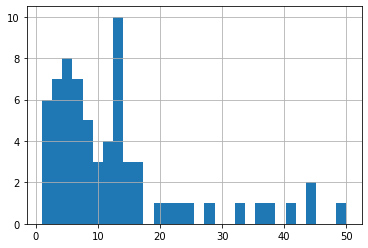

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.cleaned_tweeet]

print(max(seq_len))
pd.Series(seq_len).hist(bins = 30);

In [ ]:
# perform all the steps of pre-processing
def do_preprocoessing(df):
  preprocessed_tweet_ls = []
  encoded_tweet_ls = []
  for ix, row in df.iterrows():
    # remove numbers
    row.cleaned_tweeet = remove_numbers(row.cleaned_tweeet)

    # remove punctuation
    row.cleaned_tweeet = remove_punctuation(row.cleaned_tweeet)
    
    # tokenize a string
    word_tokens = tokenize(row.cleaned_tweeet)
    
    # remove stopwords
    word_tokens = remove_stopwords(word_tokens)
    
    # lemmatize a list of word
    word_tokens = lemmatize_word(word_tokens)

    # create a full string after pre-processing
    preprocessed_tweet = " ".join(word_tokens)
    preprocessed_tweet_ls.append(preprocessed_tweet)

  df["preprocessed_tweet"] = preprocessed_tweet_ls

  return df

In [ ]:
try:
  n_df = do_preprocoessing(df)
except:
  print(traceback.print_exc())

In [ ]:
n_df.head()

,tweet_id,original_tweet,cleaned_tweeet,year,month,day,time,labels,preprocessed_tweet
0,1.250000e+18,@28delayslater @justpaulinelol Dogecoin Mode,dogecoin mode,2020,4,25,13:29:52,1,dogecoin mode
1,1.280000e+18,"@izzynobre Excuse me, I only sell Doge!","excuse me, i only sell doge!",2020,7,18,00:53:43,-1,excuse sell doge
2,1.340000e+18,One word: Doge,one word: doge,2020,12,20,09:30:04,1,one word doge
3,1.420000e+18,@AshleyIllusion1 @lexfridman Lil X is hodling ...,lil x is hodling his doge like a champ. litera...,2021,7,17,16:53:53,0,lil x hodling doge like champ literally never ...
4,1.410000e+18,"@CGDaveMac Maybe if it sees a Shiba Inu, the c...","maybe if it sees a shiba inu, the car renders ...",2021,7,13,02:33:26,0,maybe see shiba inu car render dogecoin …


### positive, negative and neutral df

In [ ]:
len(n_df)

68

In [ ]:
pos_df = n_df[n_df.labels==1]
pos_df = pos_df.sample(frac=1)
len(pos_df)

38

In [ ]:
neg_df = n_df[n_df.labels==-1]
neg_df = neg_df.sample(frac=1)
len(neg_df)

5

In [ ]:
neu_df = n_df[n_df.labels==0]
neu_df = neu_df.sample(frac=1)
len(neu_df)

25

In [ ]:
train_percentage = 60
test_percentage = 20
valid_percentage = 20

### calculate class ratios for pos

In [ ]:
pos_train_n = len(pos_df)*(train_percentage/100)
if (pos_train_n - int(pos_train_n)) >= 0.5:
  pos_train_n = int(pos_train_n)+1
else:
  pos_train_n = int(pos_train_n)
pos_train_n

23

In [ ]:
pos_test_n = len(pos_df)*(test_percentage/100)
if (pos_test_n - int(pos_test_n)) >= 0.5:
  pos_test_n = int(pos_test_n)+1
else:
  pos_test_n = int(pos_test_n)
pos_test_n

8

In [ ]:
pos_valid_n = len(pos_df)*(valid_percentage/100)
if (pos_valid_n - int(pos_valid_n)) >= 0.5:
  pos_valid_n = int(pos_valid_n)+1
else:
  pos_valid_n = int(pos_valid_n)
pos_valid_n

8

### calculate class ratios for neg

In [ ]:
neg_train_n = len(neg_df)*(train_percentage/100)
if (neg_train_n - int(neg_train_n)) >= 0.5:
  neg_train_n = int(neg_train_n)+1
else:
  neg_train_n = int(neg_train_n)
neg_train_n

3

In [ ]:
neg_test_n = len(neg_df)*(test_percentage/100)
if (neg_test_n - int(neg_test_n)) >= 0.5:
  neg_test_n = int(neg_test_n)+1
else:
  neg_test_n = int(neg_test_n)
neg_test_n

1

In [ ]:
neg_valid_n = len(neg_df)*(valid_percentage/100)
if (neg_valid_n - int(neg_valid_n)) >= 0.5:
  neg_valid_n = int(neg_valid_n)+1
else:
  neg_valid_n = int(neg_valid_n)
neg_valid_n

1

### calculate class ratios for neu

In [ ]:
neu_train_n = len(neu_df)*(train_percentage/100)
if (neu_train_n - int(neu_train_n)) >= 0.5:
  neu_train_n = int(neu_train_n)+1
else:
  neu_train_n = int(neu_train_n)
neu_train_n

15

In [ ]:
neu_test_n = len(neu_df)*(test_percentage/100)
if (neu_test_n - int(neu_test_n)) >= 0.5:
  neu_test_n = int(neu_test_n)+1
else:
  neu_test_n = int(neu_test_n)
neu_test_n

5

In [ ]:
neu_valid_n = len(neu_df)*(valid_percentage/100)
if (neu_valid_n - int(neu_valid_n)) >= 0.5:
  neu_valid_n = int(neu_valid_n)+1
else:
  neu_valid_n = int(neu_valid_n)
neu_valid_n

5

### train, test and valid df

In [ ]:
train_pos_df = pos_df.iloc[0:pos_train_n, 0:]
train_neg_df = neg_df.iloc[0:neg_train_n, 0:]
train_neu_df = neu_df.iloc[0:neu_train_n, 0:]
train_df = train_pos_df.append([train_neg_df, train_neu_df]).sample(frac=1)
train_df.labels = train_df.labels.replace({-1:0, 0:1, 1:2})

print(len(train_df))
train_df.head()

41


,tweet_id,original_tweet,cleaned_tweeet,year,month,day,time,labels,preprocessed_tweet
26,1.390000e+18,Working with Doge devs to improve system trans...,working with doge devs to improve system trans...,2021,5,13,22:45:16,2,work doge devs improve system transaction effi...
37,1.460000e+18,@BillyM2k How about my lil doge Floki? He woul...,how about my lil doge floki? he would make a g...,2021,11,2,20:36:20,1,lil doge floki would make great ceo judgment 🤌
1,1.280000e+18,"@izzynobre Excuse me, I only sell Doge!","excuse me, i only sell doge!",2020,7,18,00:53:43,0,excuse sell doge
62,1.530000e+18,"Tesla merch can be bought with Doge, soon Spac...","tesla merch can be bought with doge, soon spac...",2022,5,27,15:27:21,2,tesla merch buy doge soon spacex merch
8,1.410000e+18,Release the Doge! https://t.co/9bXCWQLIhu,release the doge!,2021,7,1,08:43:41,2,release doge


In [ ]:
test_pos_df = pos_df.iloc[pos_train_n:pos_train_n+pos_test_n, 0:]
test_neg_df = neg_df.iloc[neg_train_n:neg_train_n+neg_test_n, 0:]
test_neu_df = neu_df.iloc[neu_train_n:neu_train_n+neu_test_n, 0:]
test_df = test_pos_df.append([test_neg_df, test_neu_df]).sample(frac=1)
test_df.labels = test_df.labels.replace({-1:0, 0:1, 1:2})

print(len(test_df))
test_df.head()

14


,tweet_id,original_tweet,cleaned_tweeet,year,month,day,time,labels,preprocessed_tweet
22,1.400000e+18,How much is that Doge in the window? https://t...,how much is that doge in the window?,2021,5,20,10:41:00,2,much doge window
25,1.390000e+18,"@itsALLrisky Ideally, Doge speeds up block tim...","ideally, doge speeds up block time 10x, increa...",2021,5,16,01:20:45,1,ideally doge speed block time x increase block...
29,1.390000e+18,The Dogefather\nSNL May 8,the dogefather snl may 8,2021,4,28,06:20:47,1,dogefather snl may
40,1.370000e+18,@beeple 420M Doge,420m doge,2021,3,15,23:11:50,2,doge
57,1.360000e+18,"No highs, no lows, only Doge","no highs, no lows, only doge",2021,2,4,08:27:10,2,highs low doge


In [ ]:
valid_pos_df = pos_df.iloc[pos_train_n+pos_test_n:(pos_train_n+pos_test_n+pos_valid_n), 0:]
valid_neg_df = neg_df.iloc[neg_train_n+neg_test_n:(neg_train_n+neg_test_n+neg_valid_n), 0:]
valid_neu_df = neu_df.iloc[neu_train_n+neu_test_n:(neu_train_n+neu_test_n+neu_valid_n), 0:]
valid_df = valid_pos_df.append([valid_neg_df, valid_neu_df]).sample(frac=1)
valid_df.labels = valid_df.labels.replace({-1:0, 0:1, 1:2})

print(len(valid_df))
valid_df.head()

13


,tweet_id,original_tweet,cleaned_tweeet,year,month,day,time,labels,preprocessed_tweet
3,1.420000e+18,@AshleyIllusion1 @lexfridman Lil X is hodling ...,lil x is hodling his doge like a champ. litera...,2021,7,17,16:53:53,1,lil x hodling doge like champ literally never ...
7,1.410000e+18,"Baby Doge, doo, doo, doo, doo, doo,\nBaby Doge...","baby doge, doo, doo, doo, doo, doo, baby doge,...",2021,7,1,09:24:21,2,baby doge doo doo doo doo doo baby doge doo do...
33,1.470000e+18,Tesla will make some merch buyable with Doge &...,tesla will make some merch buyable with doge &...,2021,12,14,10:34:23,2,tesla make merch buyable doge amp see go
31,1.380000e+18,@WSBChairman Doge Barking at the Moon – Miro h...,doge barking at the moon – miro,2021,4,15,04:28:47,2,doge bark moon – miro
54,1.360000e+18,"@itsALLrisky Doge appears to be inflationary, ...","doge appears to be inflationary, but is not me...",2021,2,8,05:27:36,2,doge appear inflationary meaningfully fix coin...


## DataLoader

In [ ]:
def tokenize(utterance, tokenizer):
    encoded = tokenizer(utterance, padding="max_length", max_length=50, truncation=True)
    for key in ["input_ids", "attention_mask", "token_type_ids"]:
        encoded[key]=torch.LongTensor((encoded[key]))
    return encoded["input_ids"], encoded["attention_mask"], encoded["token_type_ids"]

In [ ]:
class DataContext():

    def __init__(self):
        self.tokenizer=None
        self.train_dataset=None
        self.valid_dataset=None
        self.test_dataset=None
        self.train_dataloader=None
        self.valid_dataloader=None
        self.test_dataloader=None
        self.df=None

In [ ]:
class PandasDataset(Dataset):

    def __init__(self, context, dataset):

        self.max_seq_length=50
        self.tokenizer=context.tokenizer
        self.df=context.df
        self.context=context
        self.lock=threading.Lock()
        self.df=dataset

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            self.lock.acquire()
            row=self.df.iloc[idx]
        finally:
            self.lock.release()

        x = tokenize(row["preprocessed_tweet"], self.tokenizer)
        if len(x)==3:
            input_ids, attention_mask, token_type_ids=x
        else:
            raise Exception()

        sample={
            "idx": idx,
            "df_id": row["tweet_id"],
            "text": row["preprocessed_tweet"],
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }

        sample["labels"]=row["labels"]

        if token_type_ids is not None:
            sample["token_type_ids"]=token_type_ids

        # delete data that we do not need because they confuse huggingfaces trainer
        for key in list(sample.keys()):
            if key not in ['input_ids', 'attention_mask', 'labels', 'token_type_ids']:
                del sample[key]

        return sample


In [ ]:
def load_dataContext(train_df, test_df, valid_df, batch_size,  shuffle_train=True) -> DataContext:
  context = DataContext()
  context.tokenizer=BertTokenizer.from_pretrained("bert-base-uncased", model_max_length=50)

  context.train_dataset=PandasDataset(context, train_df)
  context.test_dataset=PandasDataset(context, test_df)
  context.valid_dataset=PandasDataset(context, valid_df)

  num_workers=0
  context.train_dataloader=DataLoader(context.train_dataset, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
  context.valid_dataloader=DataLoader(context.valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
  context.test_dataloader=DataLoader(context.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  return context

## Model and Trainer 

In [ ]:
# export LOCAL_RANK=-1 

In [ ]:
def load_base_model(num_labels, sub_dir, model_name, pretrained_model_path=None):
  if pretrained_model_path is not None:
    model=BertForSequenceClassification.from_pretrained(os.path.join(pretrained_model_path, sub_dir))
  elif model_name == "bert-base-uncased":
     config = BertConfig.from_pretrained(model_name,num_labels=num_labels)
     model = BertForSequenceClassification(config)
  elif model_name == "distilbert-base-uncased":
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
  else:
    raise Exception(f"unknown model \"{model_name}\"")
  
  num_p=sum(p.numel() for p in model.parameters())
  logging.info(f"loaded model with {num_p:,} parameters.")

  return  model

In [ ]:
# load a trainer, either with adapter or without
def load_trainer(model, batch_size, num_epochs, learning_rate, output_dir, data_context):

    training_args = TrainingArguments(
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_steps=200,
        output_dir=output_dir,
        overwrite_output_dir=True,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        save_total_limit=None,
        local_rank=-1,
        ddp_find_unused_parameters=False,
    )

    def compute_accuracy(p: EvalPrediction):
      # print(dir(p))
      preds = np.argmax(p.predictions, axis=1)
      return {"acc": (preds == p.label_ids).mean()}

    trainer_args={
        "model": model,
        "args": training_args,
        "train_dataset": data_context.train_dataset,
        "eval_dataset": data_context.valid_dataset,
        "compute_metrics": compute_accuracy,
        "callbacks": [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.002)]
    }


    trainer=Trainer(**trainer_args)

    return trainer

## Trainning

In [ ]:
def train(data_context, batch_size, num_epochs, learning_rate, model_name, output_dir="/content/"):
  labels = [0, 1, 2]
  model=load_base_model(len(labels), output_dir, model_name)
  trainer=load_trainer(model, batch_size, num_epochs, learning_rate, output_dir, data_context)

  starttime=time.time()
  trainer.train()
  duration=(time.time()-starttime)

  logging.info(f"training finished in {(duration/60):.2f} minutes")

  model.save_pretrained(output_dir)

  return model, trainer, duration

In [ ]:
def single_experiment(learning_rate, batch_size, num_epochs, model_name, test_on_valid = False):
  experiment_start_time=time.time()

  def prediction_helper(results, y_ture):
    y_pred=[p.argmax() for p in results.predictions]

    acc=accuracy_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred, average="micro")
    return y_true, y_pred, acc, f1

  logging.info(f"train classifier!!")
  data_context = load_dataContext(train_df, test_df, valid_df, batch_size)
  model, trainer, duration=train(data_context, batch_size, num_epochs, learning_rate, model_name)

  model = model.to(model.device)
  test_set=data_context.valid_dataset if test_on_valid else data_context.test_dataset
  y_true=[i for i in test_set.df.labels]
  starttime=time.time()
  result=trainer.predict(test_set)
  duration=(time.time()-starttime)
  y_true, y_pred, acc, f1=prediction_helper(result, y_true)
  print(f"Model: {model_name}, Accuracy: {acc}, F1-score: {f1}, lr: {learning_rate}, batch_size: {batch_size}")

In [ ]:
for model_name in ["bert-base-uncased", "distilbert-base-uncased"]:
  for batch_size in [8,16,32,64,128,256,512]:
      for learning_rate in [5e-3, 1e-4, 3e-4, 5e-4]:
        single_experiment(learning_rate, batch_size, 100, model_name)
        print()

bert-base-uncased


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 41
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 600


Epoch,Training Loss,Validation Loss,Acc
1,No log,1.500362,0.538462
2,No log,2.599978,0.384615


***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint-6 (score: 1.5003618001937866).
Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin
***** Running Prediction *****
  Num examples = 14
  Batch size = 8


Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.005, batch_size: 8

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,0.963376,0.538462
2,No log,0.910203,0.538462
3,No log,0.920830,0.384615


***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-18
Configuration saved in /content/checkpoint-18/config.json
Model weights saved in /content/checkpoint-18/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint-12 (score: 0.910203218460083).
Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin
***** Running Prediction ***

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0001, batch_size: 8

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.248428,0.538462
2,No log,1.552096,0.384615


***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint-6 (score: 1.2484277486801147).
Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin
***** Running Prediction *****
  Num examples = 14
  Batch size = 8


Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0003, batch_size: 8

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.077692,0.538462
2,No log,1.015687,0.384615
3,No log,0.918898,0.538462
4,No log,0.942688,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-18
Configuration saved in /content/checkpoint-18/config.json
Model weights saved in /content/checkpoint-18/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8
Saving model checkpoint to /content/checkpoint-24
Configuration saved in /content/checkpoint-24/config.json
Model weights saved in /content/checkpoint-24/pytorch_model.bin


Training completed. Do not forget to shar

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0005, batch_size: 8

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,6.278138,0.076923
2,No log,3.403498,0.384615
3,No log,1.345056,0.538462
4,No log,1.505598,0.384615


***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-3
Configuration saved in /content/checkpoint-3/config.json
Model weights saved in /content/checkpoint-3/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-9
Configuration saved in /content/checkpoint-9/config.json
Model weights saved in /content/checkpoint-9/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin


Training completed. Do not forget to share 

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.005, batch_size: 16

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.192184,0.384615
2,No log,0.935741,0.538462
3,No log,0.919915,0.384615
4,No log,0.906889,0.538462
5,No log,0.930316,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-3
Configuration saved in /content/checkpoint-3/config.json
Model weights saved in /content/checkpoint-3/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-9
Configuration saved in /content/checkpoint-9/config.json
Model weights saved in /content/checkpoint-9/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin
***** Running Evaluation *****
  Num examples

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0001, batch_size: 16

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.024374,0.384615
2,No log,0.912875,0.538462
3,No log,0.902286,0.538462
4,No log,1.080253,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-3
Configuration saved in /content/checkpoint-3/config.json
Model weights saved in /content/checkpoint-3/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-9
Configuration saved in /content/checkpoint-9/config.json
Model weights saved in /content/checkpoint-9/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin


Training completed. Do not forget to share 

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0003, batch_size: 16

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.966084,0.538462
2,No log,1.391456,0.538462
3,No log,0.929950,0.538462
4,No log,0.919690,0.538462
5,No log,1.214597,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-3
Configuration saved in /content/checkpoint-3/config.json
Model weights saved in /content/checkpoint-3/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-9
Configuration saved in /content/checkpoint-9/config.json
Model weights saved in /content/checkpoint-9/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 16
Saving model checkpoint to /content/checkpoint-12
Configuration saved in /content/checkpoint-12/config.json
Model weights saved in /content/checkpoint-12/pytorch_model.bin
***** Running Evaluation *****
  Num examples

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0005, batch_size: 16

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,5.208806,0.538462
2,No log,6.511546,0.076923


***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-2
Configuration saved in /content/checkpoint-2/config.json
Model weights saved in /content/checkpoint-2/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-4
Configuration saved in /content/checkpoint-4/config.json
Model weights saved in /content/checkpoint-4/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint-2 (score: 5.208806037902832).
Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin
***** Running Prediction *****
  Num examples = 14
  Batch size = 32


Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.005, batch_size: 32

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,1.249812,0.384615
2,No log,1.136329,0.538462
3,No log,0.992666,0.538462
4,No log,0.918667,0.538462
5,No log,0.904516,0.538462
6,No log,0.910376,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-2
Configuration saved in /content/checkpoint-2/config.json
Model weights saved in /content/checkpoint-2/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-4
Configuration saved in /content/checkpoint-4/config.json
Model weights saved in /content/checkpoint-4/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-8
Configuration saved in /content/checkpoint-8/config.json
Model weights saved in /content/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0001, batch_size: 32

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,3.050743,0.384615
2,No log,1.486931,0.538462
3,No log,1.004171,0.538462
4,No log,1.031181,0.384615


***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-2
Configuration saved in /content/checkpoint-2/config.json
Model weights saved in /content/checkpoint-2/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-4
Configuration saved in /content/checkpoint-4/config.json
Model weights saved in /content/checkpoint-4/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-8
Configuration saved in /content/checkpoint-8/config.json
Model weights saved in /content/checkpoint-8/pytorch_model.bin


Training completed. Do not forget to share you

Model: bert-base-uncased, Accuracy: 0.5714285714285714, F1-score: 0.5714285714285714, lr: 0.0003, batch_size: 32

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,3.988637,0.384615
2,No log,2.000713,0.384615
3,No log,1.604743,0.538462
4,No log,1.122078,0.538462
5,No log,1.076573,0.384615
6,No log,1.120869,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-2
Configuration saved in /content/checkpoint-2/config.json
Model weights saved in /content/checkpoint-2/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-4
Configuration saved in /content/checkpoint-4/config.json
Model weights saved in /content/checkpoint-4/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-6
Configuration saved in /content/checkpoint-6/config.json
Model weights saved in /content/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 32
Saving model checkpoint to /content/checkpoint-8
Configuration saved in /content/checkpoint-8/config.json
Model weights saved in /content/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 

Model: bert-base-uncased, Accuracy: 0.35714285714285715, F1-score: 0.35714285714285715, lr: 0.0005, batch_size: 32

bert-base-uncased


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Epoch,Training Loss,Validation Loss,Acc
1,No log,2.750160,0.538462
2,No log,3.659176,0.538462


***** Running Evaluation *****
  Num examples = 13
  Batch size = 64
Saving model checkpoint to /content/checkpoint-1
Configuration saved in /content/checkpoint-1/config.json
Model weights saved in /content/checkpoint-1/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 64
Saving model checkpoint to /content/checkpoint-2
Configuration saved in /content/checkpoint-2/config.json
Model weights saved in /content/checkpoint-2/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/checkpoint-1 (score: 2.7501604557037354).


TypeError: ignored